<a href="https://colab.research.google.com/github/DavoII/handwritten_letters_recognition/blob/master/Armenian_Letters(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import random
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from keras.utils import np_utils
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [6]:
data = np.load('drive/My Drive/uppercase_without_Զ/data.npy', encoding='bytes') 
labels = np.load('drive/My Drive/uppercase_without_Զ/labels.npy', encoding='bytes') 
class_idx = np.load('drive/My Drive/uppercase_without_Զ/label_classes.npy', encoding='bytes')

print(data.shape)
print(labels.shape)

(40845, 100, 100)
(40845, 38)


In [7]:
number_classes = len(class_idx)
print('number of classes', number_classes)

number of classes 38


In [0]:
x_train, x_test, y_train, y_test = train_test_split(
    data, labels,
    test_size=0.3,
    random_state=42,
    shuffle=True,
    stratify=labels
    )

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

x_train /= 255
x_test /= 255

In [0]:
x_train = x_train.reshape(x_train.shape[0], 100, 100, 1)
x_test = x_test.reshape(x_test.shape[0], 100, 100, 1)

In [12]:
print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train (28591, 100, 100, 1)
y_train (28591, 38)
x_test (12254, 100, 100, 1)
y_test (12254, 38)


In [0]:
ly1_neurons = 114
ly2_neurons = 384
ly3_neurons = 656
ly4_neurons = 768

kernel_size_1 = (7, 7)
kernel_size_2 = (3, 3)
kernel_size_3 = (7, 7)
kernel_size_4 = (7, 7)

dropout_1 = 0.15
dropout_2 = 0.2
dropout_3 = 0.25
dropout_4 = 0.25

categories=number_classes

model = Sequential()

model.add(Conv2D(ly1_neurons, kernel_size_1, input_shape=x_train.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(dropout_1))

model.add(Conv2D(ly2_neurons, kernel_size_2))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(dropout_2))

model.add(Conv2D(ly3_neurons, kernel_size_3))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(dropout_3))

model.add(Conv2D(ly4_neurons, kernel_size_4))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(dropout_4))

model.add(Flatten())
model.add(Dense( 512 ))
model.add(Activation('relu'))
model.add(Dense( categories ))
model.add(Activation('softmax'))

In [0]:
learning_rate = 0.0001
model.compile(optimizer=optimizers.Adam(
    learning_rate=learning_rate
), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 114)       5700      
_________________________________________________________________
activation (Activation)      (None, 94, 94, 114)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 114)       0         
_________________________________________________________________
dropout (Dropout)            (None, 47, 47, 114)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 384)       394368    
_________________________________________________________________
activation_1 (Activation)    (None, 45, 45, 384)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 384)      

In [16]:
gen = ImageDataGenerator(rotation_range=12, width_shift_range=0.1, shear_range=0.3,
                        height_shift_range=0.1, zoom_range=0.1, data_format='channels_first')

batch_size = 512
batches = gen.flow(x_train, y_train, batch_size=batch_size)
test_batches = gen.flow(x_test, y_test, batch_size=batch_size)
steps_per_epoch = int(np.ceil(batches.n/batch_size))
validation_steps = int(np.ceil(test_batches.n/batch_size))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_first" (channels on axis 1), i.e. expected either 1, 3, or 4 channels on axis 1. However, it was passed an array with shape (28591, 100, 100, 1) (100 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_first" (channels on axis 1), i.e. expected either 1, 3, or 4 channels on axis 1. However, it was passed an array with shape (12254, 100, 100, 1) (100 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [17]:
model.fit(
    batches,
    epochs=4,
    validation_data=test_batches,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
    )

Epoch 1/4


ResourceExhaustedError: ignored

In [0]:
model.fit(x_train, y_train, epochs=10, batch_size=120, validation_data=(x_test, y_test))

Epoch 1/10
148/239 [=================>............] - ETA: 1:04 - loss: 2.0886 - accuracy: 0.4309

In [0]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

KeyboardInterrupt: ignored

In [0]:
test_predictions = model.predict_classes(x_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [0]:
y_test_asCategories = np.argmax(y_test, axis=1)

In [0]:
confusion = confusion_matrix(y_test_asCategories, test_predictions)

Text(0.5, 1.0, 'Letter: Ք')

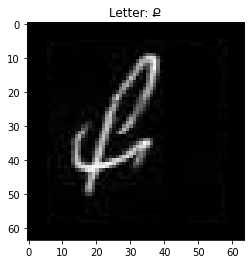

In [0]:
image_index = random.randint(1,len(x_test))

image = x_test[image_index]
plt.imshow(image[:,:,0], cmap='gray', interpolation='none')

image = np.expand_dims(image, axis=0)
scores = model.predict(image)

index = np.argmax(scores)
plt.title("Letter: " + class_idx[ index ])

In [0]:
def build_model(hp):

  categories=number_classes

  ly1_neurons = hp.Int('conv_1_filter', min_value=64, max_value=512, step=16)
  ly2_neurons = hp.Int('conv_2_filter', min_value=64, max_value=512, step=16)
  ly3_neurons = hp.Int('conv_3_filter', min_value=64, max_value=512, step=16)
  ly4_neurons = hp.Int('conv_4_filter', min_value=64, max_value=512, step=16)

  kernel_size_1 = hp.Choice('conv_1_kernel', values=[3, 5, 7])
  kernel_size_2 = hp.Choice('conv_2_kernel', values=[3, 5, 7])
  kernel_size_3 = hp.Choice('conv_3_kernel', values=[3, 5, 7])
  kernel_size_4 = hp.Choice('conv_4_kernel', values=[3, 5, 7])

  ly1_dropout = hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
  ly2_dropout = hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
  ly3_dropout = hp.Float('dropout_3', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
  ly4_dropout = hp.Float('dropout_4', min_value=0.0, max_value=0.5, default=0.25, step=0.05)

  pool_size_1 = (2, 2)
  pool_size_2 = (2, 2)
  pool_size_3 = (2, 2)
  pool_size_4 = (2, 2)

  model = Sequential()
  
  model.add(Conv2D(filters=ly1_neurons, kernel_size=kernel_size_1, input_shape=x_train.shape[1:]))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=pool_size_1))
  model.add(Dropout(ly1_dropout))

  model.add(Conv2D(filters=ly2_neurons, kernel_size=kernel_size_2))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=pool_size_2))
  model.add(Dropout(ly2_dropout))

  model.add(Conv2D(filters=ly3_neurons, kernel_size=kernel_size_3))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=pool_size_3))
  model.add(Dropout(ly3_dropout))

  model.add(Conv2D(filters=ly4_neurons, kernel_size=kernel_size_4))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=pool_size_4))
  model.add(Dropout(ly4_dropout))

  model.add(Flatten())
  model.add(Dense( 512 ))
  model.add(Activation('relu'))
  model.add(Dense( categories ))
  model.add(Activation('softmax'))

  model.compile(
      optimizer=optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-4])),
      loss='categorical_crossentropy',
      metrics=['accuracy']
      )

  return model


In [49]:
!pip install keras-tuner

In [0]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [58]:
tuner_search = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=100,
    )

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


In [59]:
tuner_search.search(x_train, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
 637/1506 [===========>..................] - ETA: 51s - loss: 4.2391 - accuracy: 0.0254

KeyboardInterrupt: ignored

In [0]:
model_from_tunner = tuner_search.get_best_models(num_models=1)[0]

In [0]:
model_from_tunner.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 114, 114, 144)     7200      
_________________________________________________________________
activation (Activation)      (None, 114, 114, 144)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 57, 57, 144)       0         
_________________________________________________________________
dropout (Dropout)            (None, 57, 57, 144)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 55, 384)       498048    
_________________________________________________________________
activation_1 (Activation)    (None, 55, 55, 384)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 384)       0

In [0]:
history = model_from_tunner.fit(
    x_train,
    y_train,
    batch_size=120,
    epochs=10,
    validation_data=(x_test, y_test),
    verbose=1
    )

Epoch 1/10
502/502 [==============================] - 171s 341ms/step - loss: 0.0943 - accuracy: 0.9737 - val_loss: 0.2122 - val_accuracy: 0.9431
Epoch 2/10
502/502 [==============================] - 168s 335ms/step - loss: 0.0601 - accuracy: 0.9820 - val_loss: 0.2208 - val_accuracy: 0.9440
Epoch 3/10
502/502 [==============================] - 168s 335ms/step - loss: 0.0449 - accuracy: 0.9857 - val_loss: 0.2380 - val_accuracy: 0.9411
Epoch 4/10
502/502 [==============================] - 168s 335ms/step - loss: 0.0380 - accuracy: 0.9872 - val_loss: 0.2579 - val_accuracy: 0.9420
Epoch 5/10
502/502 [==============================] - 168s 335ms/step - loss: 0.0365 - accuracy: 0.9879 - val_loss: 0.2750 - val_accuracy: 0.9389
Epoch 6/10
502/502 [==============================] - 168s 335ms/step - loss: 0.0338 - accuracy: 0.9887 - val_loss: 0.2697 - val_accuracy: 0.9411
Epoch 7/10
502/502 [==============================] - 168s 334ms/step - loss: 0.0287 - accuracy: 0.9899 - val_loss: 0.2988 -